# ccdproc-01:   Classify images  

## Overview
1. Start CCD reduction using ccdproc
2. Creating lists of images 
3. Examples

<pre>
Máster en Astrofísica UCM  -- Técnicas Experimentales en Astrofísica  
Jaime Zamorano and Nicolás Cardiel

This notebook has reproduced parts of the the astropy ccdproc docs: 
https://ccdproc.readthedocs.io/en/latest/image_management.html

Version 1.0 2021/01/11  
</pre>

Note that the ``astropy`` package should be installed. In this sense, have a look to the
astropy installation description: https://docs.astropy.org/en/stable/install.html.

In [1]:
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
plt.style.use('./tea.mplstyle')

### Working with images in a directory
We will use the files of the first night of observations at NOT (Nordic Optical Telescope) 2008 that can be downloaded from   ftp://astrax.fis.ucm.es/pub/users/jaz/NOT_2008_04_12-14/N1/
or 
http://guaix.fis.ucm.es/~jaz/master_TEA/observaciones_NOT_2008/N1/

``directory`` should point to the directory with the downloaded images

In [3]:
directory = 'N1'
dirname = 'N1'

In [4]:
# Version simple
# solo descarga si es necesario
#!curl -C -  -O ftp://astrax.fis.ucm.es/pub/users/jaz/NOT_2008_04_12-14/NOT_20080412_N1.tar.gz

In [5]:
# Version simple
#!mkdir -p N1
#!tar axf NOT_20080412_N1.tar.gz --strip-components=1 -C N1
# o bien
#!tar -x -f NOT_20080412_N1.tar.gz -a --strip-components=1 -C $directory

In [6]:
%%bash
# Version complicada, solo descarga si es necesario
TARBALL=NOT_20080412_N1.tar.gz
DIR=N1
URI=ftp://astrax.fis.ucm.es/pub/users/jaz/NOT_2008_04_12-14/"$TARBALL"
if [ ! -f "$TARBALL" ]; then
    echo "$TARBALL does not exist, download"
    curl -C -  -O "$URI"
fi
if  [ ! -d "$DIR" ]; then
    mkdir -p $DIR
    tar -x -f NOT_20080412_N1.tar.gz -a --strip-components=1 -C $DIR
fi

Let\'s create a list containing all the FITS files in that directory 

In [7]:
# only works in notebooks
# we can pass the python variable to shell
filelist = !ls $directory/AL*.fits

In [8]:
from pathlib import Path
p = Path(directory)
filelist = list(sorted(p.glob('AL*.fits')))
print(filelist[10:20])    # printing only from 10 to 20

[PosixPath('N1/AL12011.fits'), PosixPath('N1/AL12012.fits'), PosixPath('N1/AL12013.fits'), PosixPath('N1/AL12014.fits'), PosixPath('N1/AL12015.fits'), PosixPath('N1/AL12016.fits'), PosixPath('N1/AL12017.fits'), PosixPath('N1/AL12018.fits'), PosixPath('N1/AL12019.fits'), PosixPath('N1/AL12020.fits')]


Let\'s open one of the files to explore the HEADER keywords

In [9]:
HDUList_object = fits.open(filelist[102])
HDUList_object.info()

Filename: N1/AL12103.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     143   (2198, 2052)   int16 (rescales to uint16)   


In [10]:
primary_HDU = HDUList_object[0]

In [11]:
# Extract primary header
primary_header = primary_HDU.header

# Index header object with keyword name and print value
print(primary_header['FILENAME'],primary_header['OBJECT'])

ALrd120103.fits GC4496A R 3x300s


In [12]:
for key in primary_header:
    print('{:8} = {}'.format(key, primary_header[key]))

SIMPLE   = True
BITPIX   = 16
NAXIS    = 2
NAXIS1   = 2198
NAXIS2   = 2052
EXTEND   = False
BSCALE   = 1.0
BZERO    = 32768.0
ORIGIN   = NOAO-IRAF FITS Image Kernel July 2003
DATE     = 2014-02-26T08:05:35
IRAF-TLM = 2014-02-26T08:05:34
OBJECT   = GC4496A R 3x300s
OBSERVAT = LaPalma
TELESCOP = NOT
INSTRUME = ALFOSC_FASU
DETNAME  = EEV 2k x 2k
DATE-OBS = 2008-04-13T00:01:26
FILENAME = ALrd120103.fits
OBSERVER = 
IMAGETYP = 
EQUINOX  = 2000.0
EXPTIME  = 300.0
TM_START = 86
TM_END   = 467
GAINM    = HIGH
AMPLMODE = A
CCDTEMP  = -120.3
LN2TEMP  = -190.4
MPP      = 1
CHIPID   = E2V42-40Roy v1.6
XOVERSC  = 100
YOVERSC  = 0
P_DEWAR  = Not available
TM-START = 86
SHSTAT   = OPEN
DETXBIN  = 1
DETYBIN  = 1
NWINDOWS = 1
DETWIN1  = [   1:2198,   1:2052]
ALAPRTNM = Open
ALAPRTID = 0
ALAPRPOS = 7
ALAPRSTP = 279150
ALFLTNM  = R_Bes 650_130
ALFLTID  = 76
ALFLTPOS = 4
ALFLTSTP = 160300
ALGRNM   = Open (Lyot)
ALGRID   = 0
ALGRPOS  = 7
ALGRSTP  = 280100
ALFOCUS  = 1810
ALCENWAV = N/A
FAFLTNM  = Open
FAFL

Each telescope/instrument has differences in the ``keyword``names.  
For [ALFOSC at NOT](http://www.not.iac.es/instruments/alfosc/) instead of ``FILTER`` they write ``ALFLTID`` and  ``FBFLTID``  in the header. ALFOSC has  filterwheel A and filterwheel B and the filters should be mounted in one of the two depending of size and/or band width. More info at [NOT filters](http://www.not.iac.es/instruments/filters/)

Let\'s display this file

In [13]:
image_data = primary_HDU.data
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(2052, 2198)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


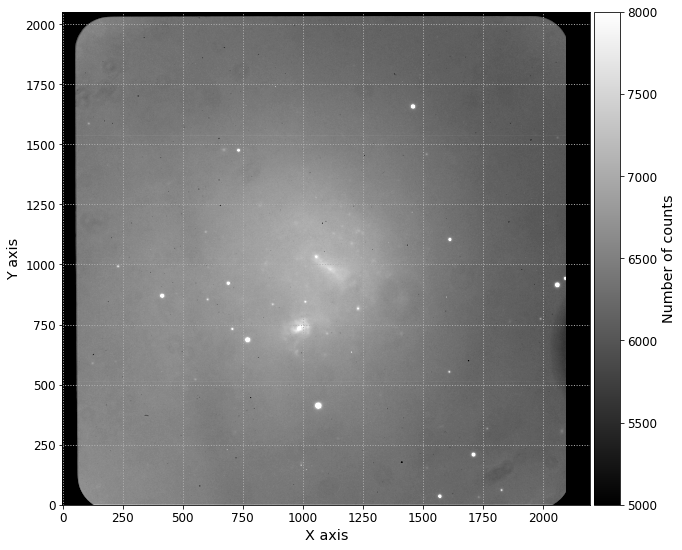

In [14]:
naxis2, naxis1 = image_data.shape

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
img = ax.imshow(image_data, vmin=5000, vmax=8000)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img, cax=cax, label='Number of counts')
ax.grid()

In [15]:
HDUList_object.close()

This is the first of three 300s exposures of NGC4496 with the R filter.    
The external parts of the chip (2052 x 2198) are black, i.e. no signal. according with the header information the region reserved for dark signal is BIASSEC  = [3:52,1:2052] but there is also a region at right. We will remove these regions by trimming the image. It is better to use ``DS9`` to select the region of interest. 

### Looking for files with different size

There are some auxiliary observations that were saved as FITS files. For instance those for focusing the telescope. There is no problem in processing them but there will be problems if there is an image with different size.

In [16]:
for fname in filelist:
    with fits.open(fname) as HDUList_object:
        primary_header = HDUList_object[0].header
        print(primary_header['FILENAME'],primary_header['OBJECT'],primary_header['NAXIS1'],primary_header['NAXIS2'])

ALrd120001.fits Bias afternoon 2198 2052
ALrd120002.fits Bias afternoon 2198 2052
ALrd120003.fits Bias afternoon 2198 2052
ALrd120004.fits Bias afternoon 2198 2052
ALrd120005.fits Bias afternoon 2198 2052
ALrd120006.fits Bias afternoon 2198 2052
ALrd120007.fits Bias afternoon 2198 2052
ALrd120008.fits Bias afternoon 2198 2052
ALrd120009.fits Bias afternoon 2198 2052
ALrd120010.fits Bias afternoon 2198 2052
ALrd120011.fits Dome Flat R 2198 2052
ALrd120012.fits Dome Flat R 2198 2052
ALrd120013.fits Dome Flat R 2198 2052
ALrd120014.fits Dome Flat R 2198 2052
ALrd120015.fits Dome Flat R 2198 2052
ALrd120016.fits Dome Flat R 2198 2052
ALrd120017.fits Dome Flat R 2198 2052
ALrd120018.fits Dome Flat R 2198 2052
ALrd120019.fits Dome Flat R 2198 2052
ALrd120020.fits Dome Flat R 2198 2052
ALrd120021.fits Dome Flat NB#78 2198 2052
ALrd120022.fits Dome Flat NB#49 2198 2052
ALrd120023.fits Dome Flat NB#78 2198 2052
ALrd120024.fits Dome Flat NB#78 2198 2052
ALrd120025.fits Dome Flat NB#78 2198 2052


The image number 63 is different with size 800,800. It is better to remove it to avoid problems during the processing.

 * ALrd120062.fits Sky Flat evening 2198 2052
 * ALrd120063.fits Sky Flat evening 800 800
 * ALrd120064.fits HZ44 focusing 2198 2052

In [9]:
!rm -f $dirname/ALrd120063.fits

### Selecting files by type and filter  
We wish to create lists containing the BIAS files to build the master BIAS or those scientific files taken with the same filter to apply the corresponding Flat Field, to name two examples.

In [17]:
from ccdproc import ImageFileCollection
from ccdproc.utils.sample_directory import sample_directory_with_files
directory = 'N1'
ic_all = ImageFileCollection(directory, keywords='*')
print(ic_all.summary.colnames)

['file', 'simple', 'bitpix', 'naxis', 'naxis1', 'naxis2', 'extend', 'bscale', 'bzero', 'origin', 'date', 'iraf-tlm', 'object', 'observat', 'telescop', 'instrume', 'detname', 'date-obs', 'filename', 'observer', 'imagetyp', 'equinox', 'exptime', 'tm_start', 'tm_end', 'gainm', 'amplmode', 'ccdtemp', 'ln2temp', 'mpp', 'chipid', 'xoversc', 'yoversc', 'p_dewar', 'tm-start', 'shstat', 'detxbin', 'detybin', 'nwindows', 'detwin1', 'alaprtnm', 'alaprtid', 'alaprpos', 'alaprstp', 'alfltnm', 'alfltid', 'alfltpos', 'alfltstp', 'algrnm', 'algrid', 'algrpos', 'algrstp', 'alfocus', 'alcenwav', 'fafltnm', 'fafltid', 'fafltpos', 'fbfltnm', 'fbfltid', 'fbfltpos', 'clamp1', 'clampnm1', 'clampid1', 'clamp2', 'clampnm2', 'clampid2', 'clamp3', 'clampnm3', 'clampid3', 'clamp4', 'clampnm4', 'clampid4', 'cmirror', 'faretard', 'faretang', 'ut', 'st', 'ra', 'dec', 'radecsys', 'telalt', 'azimuth', 'airmass', 'field', 'rotpos', 'ccdprobe', 'auxpos', 'auypos', 'aubxxpos', 'aubxypos', 'austatus', 'telfocus', 'tcstgt'

Selecting the keywords to be used in classifying the files  
ALFLTID =                   76 / ALFOSC filter wheel. NOT filter number  
FAFLTID =                    0 / FASU filter wheel 1/A NOT filter number        FBFLTID =                    0 / FASU filter wheel 2/B NOT filter number   

In [18]:
keys = ['OBJECT' , 'EXPTIME' , 'ALFLTID' , 'FAFLTID' , 'FBFLTID']
ic1 = ImageFileCollection(directory, keywords=keys) # only keep track of keys
ic1.summary.colnames

['file', 'OBJECT', 'EXPTIME', 'ALFLTID', 'FAFLTID', 'FBFLTID']

In [19]:
# matches = (ic1.summary['filter'] == 'R') & (ic1.summary['exposure'] < 15)
#matches = (ic1.summary['imagetyp'] == 'BIAS') 
#matches = (ic1.summary['FBFLTID'] == 78)
matches = (ic1.summary['EXPTIME'] > 600)
my_files = ic1.summary['file'][matches]
print(my_files)

    file    
------------
AL12092.fits
AL12093.fits
AL12094.fits
AL12098.fits
AL12099.fits
AL12100.fits
AL12107.fits
AL12108.fits
AL12109.fits
AL12113.fits
AL12114.fits
AL12115.fits
AL12119.fits
AL12120.fits
AL12121.fits
AL12135.fits


In [20]:
my_files = ic1.files_filtered(FBFLTID=78, exptime=3.5)
#my_files = ic1.files_filtered(exptime=15)
print(my_files)

['AL12046.fits']


In [21]:
bias_list = ic1.files_filtered(regex_match=True,imagetyp='bias|light')
print(bias_list)

['AL12001.fits' 'AL12002.fits' 'AL12003.fits' 'AL12004.fits'
 'AL12005.fits' 'AL12006.fits' 'AL12007.fits' 'AL12008.fits'
 'AL12009.fits' 'AL12010.fits']


In [22]:
list_of_flats = ic1.files_filtered(regex_match=True,object='flat')
print(list_of_flats)

['AL12011.fits' 'AL12012.fits' 'AL12013.fits' 'AL12014.fits'
 'AL12015.fits' 'AL12016.fits' 'AL12017.fits' 'AL12018.fits'
 'AL12019.fits' 'AL12020.fits' 'AL12021.fits' 'AL12022.fits'
 'AL12023.fits' 'AL12024.fits' 'AL12025.fits' 'AL12026.fits'
 'AL12027.fits' 'AL12028.fits' 'AL12029.fits' 'AL12030.fits'
 'AL12031.fits' 'AL12032.fits' 'AL12033.fits' 'AL12034.fits'
 'AL12035.fits' 'AL12036.fits' 'AL12037.fits' 'AL12038.fits'
 'AL12039.fits' 'AL12040.fits' 'AL12041.fits' 'AL12042.fits'
 'AL12043.fits' 'AL12044.fits' 'AL12045.fits' 'AL12046.fits'
 'AL12047.fits' 'AL12048.fits' 'AL12049.fits' 'AL12050.fits'
 'AL12051.fits' 'AL12052.fits' 'AL12053.fits' 'AL12054.fits'
 'AL12055.fits' 'AL12056.fits' 'AL12057.fits' 'AL12058.fits'
 'AL12059.fits' 'AL12060.fits' 'AL12061.fits' 'AL12062.fits'
 'AL12063.fits']
